In [1]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from dateutil import rrule
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy
from IPython.display import clear_output
import zipfile
from sklearn.metrics import r2_score
pd.set_option('display.max_columns', None)

In [2]:
#dtype = {"DIA": int, "MES": int, "AÑO": int, 'DIA DE LA SEMANA': str, 'HORA': int }
with zipfile.ZipFile('/content/turnos_tp_final.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
raw_df = pd.read_csv('/content/turnos_suc_5ed11e969aeb6c3712d4aab6.csv', dtype=str)

clima_types = { 'date': 'str', 'temperatura':'float', 'humedad':'int', 'precipitacion':'float', 'lluvia': 'float' }
with zipfile.ZipFile('/content/info_meteorologica.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
raw_df_clima = pd.read_csv('/content/info_meteorologica.csv', dtype=clima_types, parse_dates=['date'])

# Preparo el dataset

## Explicación del dataset

Este dataset corresponde a los turnos sacados por clientes reales de una famosa y muy grande farmacia de la ciudad de córdoba. Cada registro representa una persona que ingresó al local.

La idea de este proyecto es poder predecir cuántas personas vendrán el día de mañana, para así poder tomar decisiones estratégicas como mover un empleado desde una sucursal a otra.

## Selección de columnas y tratamiento de nulos

In [3]:
raw_df.isna().sum()

DIA                     9
MES                     9
AÑO                     9
DIA DE LA SEMANA        9
HORA                    9
MOTIVO                  9
socialNetwork       65083
createTS            65083
inmediate           65092
serial              65085
TIEMPO DE ESPERA        9
SEMANA DEL AÑO          9
dtype: int64

In [4]:
# Tomo solo las columnas que serán realmente útiles
initial_cols = ['AÑO', 'MES', 'DIA', 'DIA DE LA SEMANA', 'HORA']
df = raw_df[initial_cols]
# Dropeo las filas ya de las columnas usadas solo hay 9 sin datos
df = df.dropna(axis=0)
# Interpreto año, mes y hora como int para ordenar mas fácil después
df = df.astype({ 'AÑO':'int', 'MES':'int', 'DIA':'int', 'HORA':'int' })

## Conteo de turnos por hora

In [5]:
df = df.groupby(initial_cols).size().reset_index(name='COUNT')
df.head(5)

,AÑO,MES,DIA,DIA DE LA SEMANA,HORA,COUNT
0,2020,7,7,3-MAR,12,11
1,2020,7,7,3-MAR,13,15
2,2020,7,7,3-MAR,14,11
3,2020,7,7,3-MAR,15,27
4,2020,7,7,3-MAR,16,31


## Mergear datos de clima

In [6]:
raw_df_clima['AÑO_CLIMA'] = raw_df_clima.date.dt.year
raw_df_clima['MES_CLIMA'] = raw_df_clima.date.dt.month
raw_df_clima['DIA_CLIMA'] = raw_df_clima.date.dt.day
raw_df_clima['HORA_CLIMA'] = raw_df_clima.date.dt.hour

In [7]:
df = pd.merge(df, raw_df_clima,  how='left', left_on=['AÑO','MES', 'DIA', 'HORA'], right_on = ['AÑO_CLIMA','MES_CLIMA', 'DIA_CLIMA', 'HORA_CLIMA'])
df = df.drop(labels=['AÑO_CLIMA','MES_CLIMA','DIA_CLIMA','HORA_CLIMA', 'date'], axis=1)

In [8]:
# Código para rellenar horas faltantes con ceros que al final no fue usado
def hourly_it(start, finish):
     while finish > start:
             start = start + timedelta(hours=1)
             yield start

def complete_empty_hours(input_df):
    df = input_df.copy()
    start_year = df['AÑO'].iloc[0]
    start_month = df['MES'].iloc[0]
    start_day = df['DIA'].iloc[0]
    start_hour = df['HORA'].iloc[0]

    end_year = df['AÑO'].iloc[-1]
    end_month = df['MES'].iloc[-1]
    end_day = df['DIA'].iloc[-1]
    end_hour = df['HORA'].iloc[-1]

    start = datetime(start_year, start_month, start_day, start_hour)
    finish = datetime(end_year, end_month, end_day, end_hour)

    dows = ['1-DOM', '2-LUN', '3-MAR', '4-MIE', '5-JUE', '6-VIE', '7-SAB']
    for hour in hourly_it(start, finish):
        res = df.loc[(df['AÑO'] == hour.year) & (df['MES'] == hour.month) & (df['DIA'] == hour.day) & (df['HORA'] == hour.hour)]
        if(len(res) <= 0):
            to_add = {'AÑO': hour.year, 'MES': hour.month, 'DIA': hour.day, 'HORA': hour.hour, 'DIA DE LA SEMANA': dows[hour.weekday()], 'COUNT': 0}
            df = pd.concat([df, pd.DataFrame([to_add])], ignore_index=True)
    return df

#train = complete_empty_hours(train)

In [9]:
# ACÁ analisis

<Axes: xlabel='AÑO', ylabel='COUNT'>

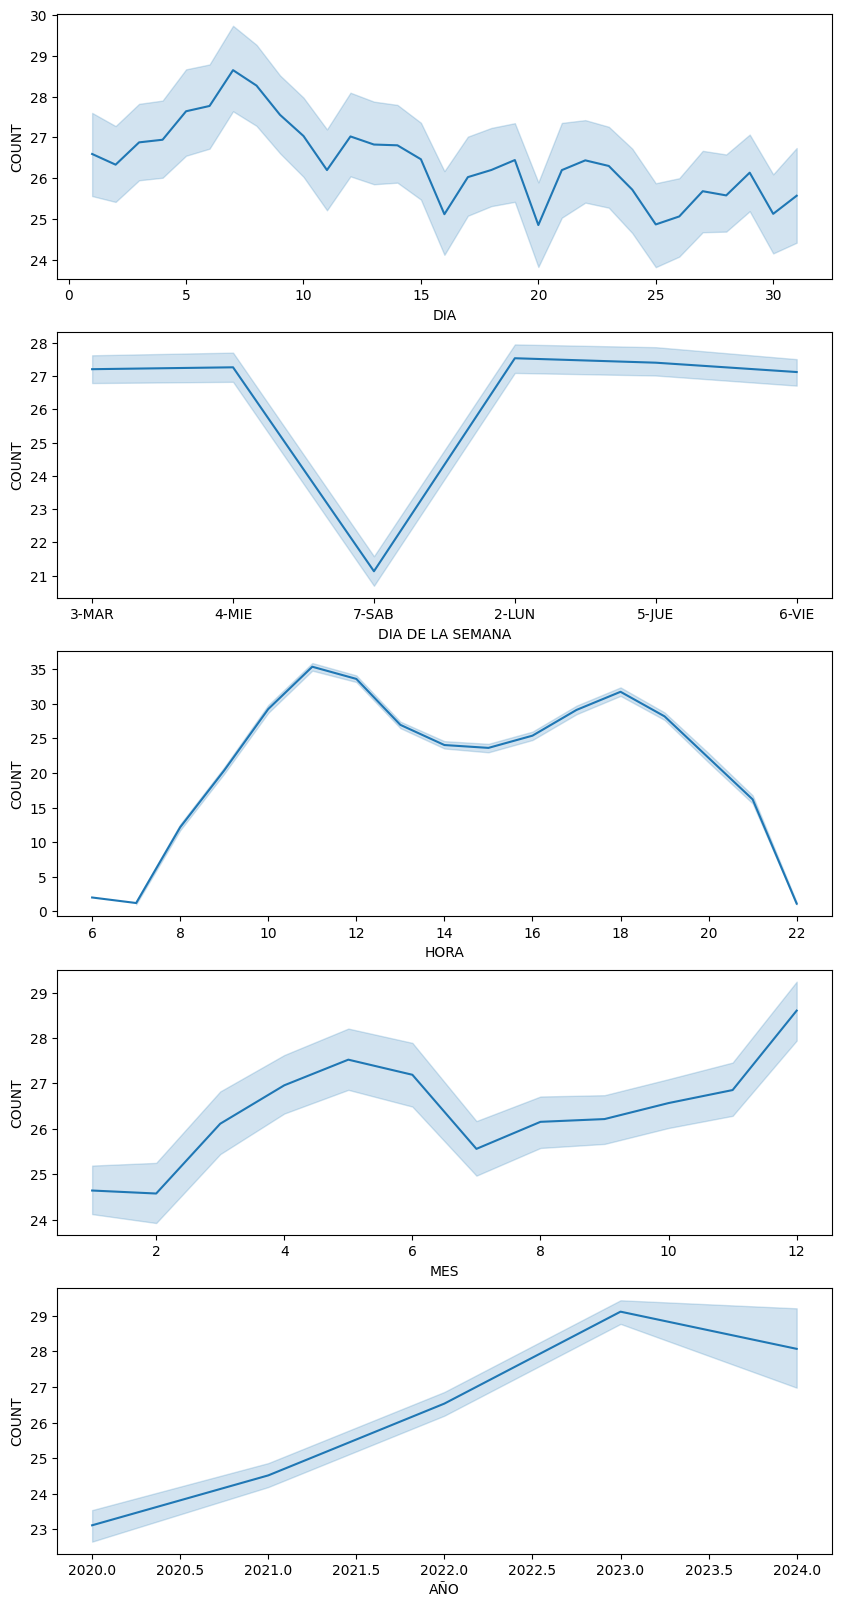

In [116]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
sns.lineplot(data=df,x="DIA", y="COUNT",ax=axes[0])
sns.lineplot(data=df,x="DIA DE LA SEMANA", y="COUNT",ax=axes[1])
sns.lineplot(data=df,x="HORA", y="COUNT",ax=axes[2])
sns.lineplot(data=df,x="MES", y="COUNT",ax=axes[3])
sns.lineplot(data=df,x="AÑO", y="COUNT",ax=axes[4])

<Axes: xlabel='precipitacion', ylabel='COUNT'>

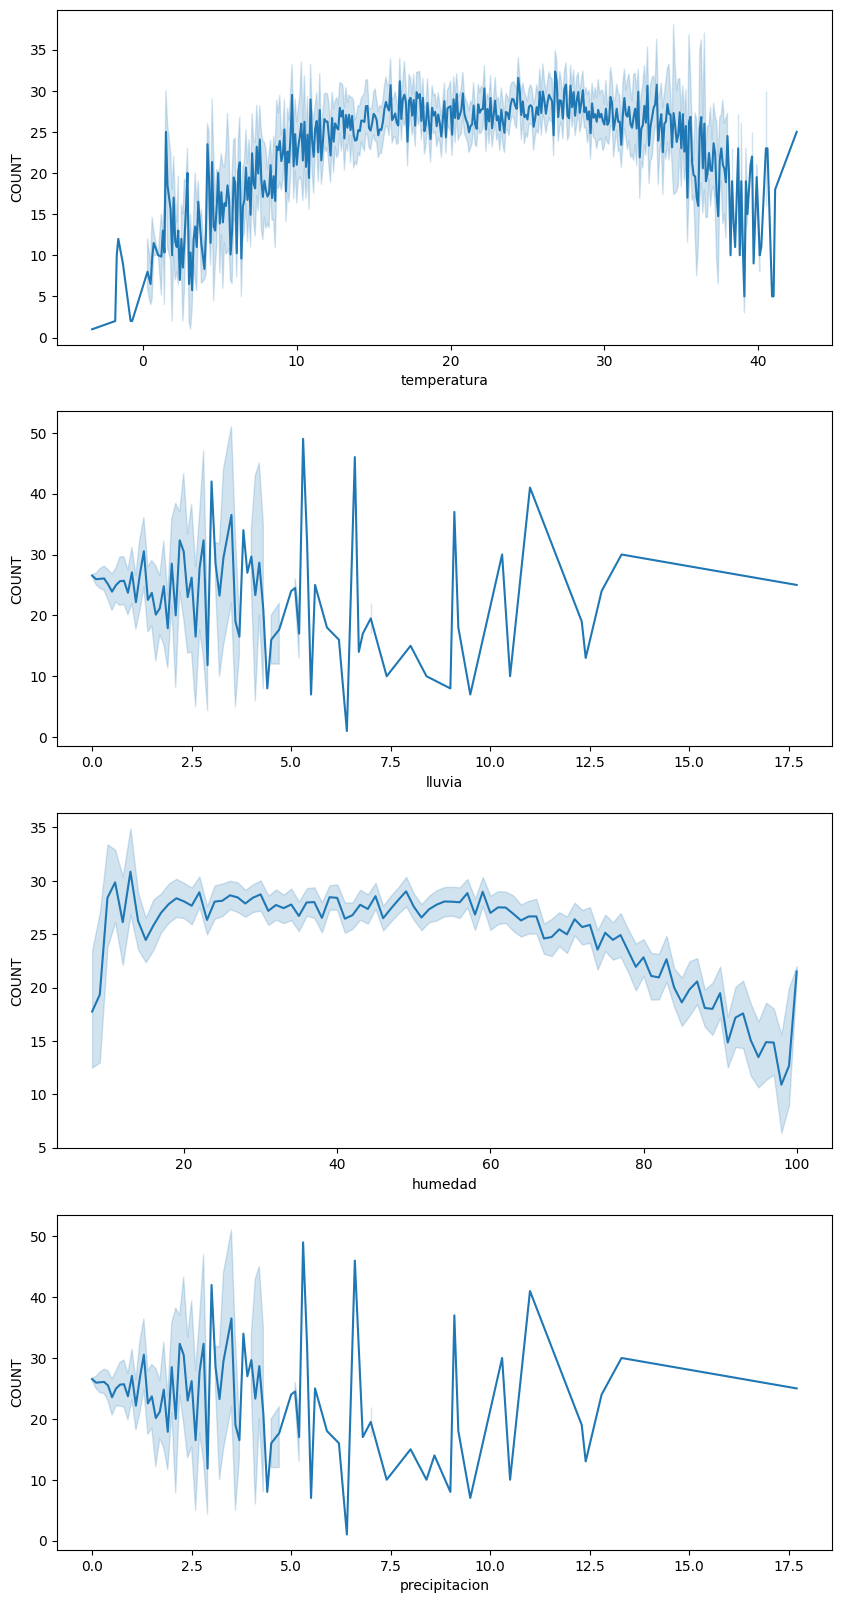

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
sns.lineplot(data=df,x="temperatura", y="COUNT",ax=axes[0])
sns.lineplot(data=df,x="lluvia", y="COUNT",ax=axes[1])
sns.lineplot(data=df,x="humedad", y="COUNT",ax=axes[2])
sns.lineplot(data=df,x="precipitacion", y="COUNT",ax=axes[3])

# Train / Test Split

In [11]:
# Ordeno el dataset por tiempo
df = df.sort_values(["AÑO", "MES", "DIA", "HORA"])

In [12]:
# Veo cual es la fecha mas baja
df.head(2)

,AÑO,MES,DIA,DIA DE LA SEMANA,HORA,COUNT,temperatura,humedad,precipitacion,lluvia
0,2020,7,7,3-MAR,12,11,7.8,68,0.0,0.0
1,2020,7,7,3-MAR,13,15,8.3,68,0.0,0.0


In [13]:
# Veo cual es la fecha mas alta
df.tail(1)

,AÑO,MES,DIA,DIA DE LA SEMANA,HORA,COUNT,temperatura,humedad,precipitacion,lluvia
13115,2024,1,29,2-LUN,21,12,28.6,46,0.0,0.0


In [14]:
df.groupby(['AÑO']).size().reset_index(name='COUNT')

,AÑO,COUNT
0,2020,1458
1,2021,3508
2,2022,3926
3,2023,3889
4,2024,335


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13116 entries, 0 to 13115
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AÑO               13116 non-null  int64  
 1   MES               13116 non-null  int64  
 2   DIA               13116 non-null  int64  
 3   DIA DE LA SEMANA  13116 non-null  object 
 4   HORA              13116 non-null  int64  
 5   COUNT             13116 non-null  int64  
 6   temperatura       13116 non-null  float64
 7   humedad           13116 non-null  int64  
 8   precipitacion     13116 non-null  float64
 9   lluvia            13116 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 1.1+ MB


Separo X e Y

In [95]:
# Me quedo con las columnas que necesito solamente
cols = ['AÑO', 'MES', 'DIA', 'HORA', 'DIA DE LA SEMANA', 'temperatura', 'humedad', 'lluvia']

# Voy a reservar los datos de 2024 para, al final, hacer un análisis de validación
train_test = df[(df['AÑO'] < 2024)]
validation = df[(df['AÑO'] >= 2024)]

X_train, X_test, y_train, y_test = train_test_split(train_test[cols], train_test['COUNT'], test_size=0.2, random_state=42)
X_validation = validation[cols]
y_validation = validation['COUNT']

In [96]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_validation = X_validation.reset_index()

In [97]:
y_train.head(2)

6497     26
11511    36
Name: COUNT, dtype: int64

In [98]:
X_train.head(2)

,index,AÑO,MES,DIA,HORA,DIA DE LA SEMANA,temperatura,humedad,lluvia
0,6497,2022,5,26,20,5-JUE,10.2,73,0.0
1,11511,2023,9,11,19,2-LUN,19.5,25,0.0


# Encoding

In [99]:
# Considero todas variables categóricas y les hago un one hot encoder
categorical_labels = ["MES", "DIA DE LA SEMANA", "HORA", "DIA"]
numerical_labels = ["AÑO", "temperatura", "humedad", "lluvia"]

# Fit del One hot encoder
ohe = OneHotEncoder()
ohe.fit(X_train[categorical_labels])

# Fit del Scaler
scaler = StandardScaler()
scaler.fit(X_train[numerical_labels])

# Encoding
encoded_categoricals = ohe.transform(X_train[categorical_labels])
encoded_categoricals_df = pd.DataFrame(data=encoded_categoricals.toarray(), columns=ohe.get_feature_names_out())

# Scaler
X_train[numerical_labels] = scaler.transform(X_train[numerical_labels])

# Concat
X_train = pd.concat([X_train[numerical_labels], encoded_categoricals_df], axis=1)

In [100]:
X_train.head(5)

,AÑO,temperatura,humedad,lluvia,MES_1,MES_2,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12,DIA DE LA SEMANA_2-LUN,DIA DE LA SEMANA_3-MAR,DIA DE LA SEMANA_4-MIE,DIA DE LA SEMANA_5-JUE,DIA DE LA SEMANA_6-VIE,DIA DE LA SEMANA_7-SAB,HORA_6,HORA_7,HORA_8,HORA_9,HORA_10,HORA_11,HORA_12,HORA_13,HORA_14,HORA_15,HORA_16,HORA_17,HORA_18,HORA_19,HORA_20,HORA_21,HORA_22,DIA_1,DIA_2,DIA_3,DIA_4,DIA_5,DIA_6,DIA_7,DIA_8,DIA_9,DIA_10,DIA_11,DIA_12,DIA_13,DIA_14,DIA_15,DIA_16,DIA_17,DIA_18,DIA_19,DIA_20,DIA_21,DIA_22,DIA_23,DIA_24,DIA_25,DIA_26,DIA_27,DIA_28,DIA_29,DIA_30,DIA_31
0,0.193922,-1.503258,1.124279,-0.136306,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.195268,-0.204667,-1.263760,-0.136306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.195268,-0.637531,-0.268744,-0.136306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.195268,-0.539787,0.129263,-0.136306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.193922,-0.316374,-0.865754,-0.136306,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# Para test

# Encoding
encoded_categoricals = ohe.transform(X_test[categorical_labels])
encoded_categoricals_df = pd.DataFrame(data=encoded_categoricals.toarray(), columns=ohe.get_feature_names_out())

# Scaler
X_test[numerical_labels] = scaler.transform(X_test[numerical_labels])

# Concat
X_test = pd.concat([X_test[numerical_labels], encoded_categoricals_df], axis=1)

In [102]:
# Para validation

# Encoding
encoded_categoricals = ohe.transform(X_validation[categorical_labels])
encoded_categoricals_df = pd.DataFrame(data=encoded_categoricals.toarray(), columns=ohe.get_feature_names_out())

# Scaler
X_validation[numerical_labels] = scaler.transform(X_validation[numerical_labels])

# Concat
X_validation = pd.concat([X_validation[numerical_labels], encoded_categoricals_df], axis=1)

In [103]:
print(X_train.shape, y_train.shape)

(10224, 70) (10224,)


In [104]:
print(X_test.shape, y_test.shape)

(2557, 70) (2557,)


# Preparación del modelo

## Recorrido de los hiperparámetros

Se plantea usar una Red Neuronal con 3 capas, dos de ellas con activación ReLu y cuya densidad se la recorrió por exponenciales de 2, en todos los casos con 100 epochs usando la función de pérdida MSE, arrojando los siguientes resultados:

Estas métricas son contra el conjunto de validación, calculando MAE y MSE, tanto para las 100 Epochs, como para la Epoch que arrojó el resultado mas bajo

In [105]:
# Preparo el modelo
histories = []
for denseFactor in range(7):
    dense = 2 ** (denseFactor+3)
    epochs = 200
    model = Sequential([
        Dense(dense, activation='relu', input_shape=[X_train.shape[1]]),
        Dense(dense, activation='relu'),
        Dense(1)
    ])
    optimizer = optimizers.Adam(0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)
    ######
    historyDf = pd.DataFrame(history.history)

    histories.append({ "dense": dense,
                      "history": historyDf,
                      "final_val_mae": historyDf.iloc[-1].val_mae,
                      "final_val_mse": historyDf.iloc[-1].val_mse,
                      "min_val_mae": historyDf.val_mae.min(),
                      "min_val_mse": historyDf.val_mse.min(),
                     })
    clear_output(wait=False)
    for h in histories:
        print(' Epochs %2d - Dense %2d - Final MAE %2f - MSE %2f - Min MAE %2f - MSE %2f'
              % (epochs, h['dense'], h['final_val_mae'], h['final_val_mse'], h['min_val_mae'], h['min_val_mse'],))




Epoch 1/200
320/320 [==============================] - 2s 3ms/step - loss: 511.4068 - mae: 19.5194 - mse: 511.4068 - val_loss: 97.6776 - val_mae: 7.9075 - val_mse: 97.6776
Epoch 2/200
320/320 [==============================] - 1s 3ms/step - loss: 80.0633 - mae: 7.1382 - mse: 80.0633 - val_loss: 64.5850 - val_mae: 6.3760 - val_mse: 64.5850
Epoch 3/200
320/320 [==============================] - 1s 3ms/step - loss: 63.9090 - mae: 6.3254 - mse: 63.9090 - val_loss: 57.5633 - val_mae: 5.9711 - val_mse: 57.5633
Epoch 4/200
320/320 [==============================] - 1s 3ms/step - loss: 58.9526 - mae: 6.0477 - mse: 58.9526 - val_loss: 55.5149 - val_mae: 5.8203 - val_mse: 55.5149
Epoch 5/200
320/320 [==============================] - 1s 3ms/step - loss: 57.1724 - mae: 5.9356 - mse: 57.1724 - val_loss: 54.7100 - val_mae: 5.7423 - val_mse: 54.7100
Epoch 6/200
320/320 [==============================] - 1s 3ms/step - loss: 55.1286 - mae: 5.8139 - mse: 55.1286 - val_loss: 52.5960 - val_mae: 5.6259 - 

KeyboardInterrupt: 

Resultado (para no tener que ejecutar todo de nuevo)

```
 Epochs 200 - Dense  8 - Final MAE 5.767829 - MSE 54.204960 - Min MAE 5.762589 - MSE 54.204960
 Epochs 200 - Dense 16 - Final MAE 5.463751 - MSE 48.474743 - Min MAE 5.424992 - MSE 48.049095
 Epochs 200 - Dense 32 - Final MAE 5.651106 - MSE 52.732220 - Min MAE 5.387898 - MSE 47.942997
 Epochs 200 - Dense 64 - Final MAE 6.317900 - MSE 63.893650 - Min MAE 5.345129 - MSE 46.703613
 Epochs 200 - Dense 128 - Final MAE 7.035202 - MSE 78.843849 - Min MAE 5.334438 - MSE 46.533459
 Epochs 200 - Dense 256 - Final MAE 6.251158 - MSE 62.231117 - Min MAE 5.344090 - MSE 46.603054
 Epochs 200 - Dense 512 - Final MAE 5.851600 - MSE 54.618069 - Min MAE 5.331388 - MSE 46.369526
 ```



## Entrenamiento final del modelo

En el resultado de la sección anterior se puede ver que la densidad de 32 resultó ser levemente superior.

Por lo que vamos a hacer uso de dicha densidad y la vamos a entrenar con 200 epochs.

El objetivo es que el modelo tenga el menor MAE posible, ya que en promedio se pretende que la predicción sea lo mas preceisa posible.

In [108]:
# Sabiendo que la mejor densidad es 32, se procedió a entrenar el modelo con mayor cantidad de epochs para ver si mejora
dense = 32
epochs = 25
model = Sequential([
    Dense(dense, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(dense, activation='relu'),
    Dense(1)
])
optimizer = optimizers.Adam(0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
320/320 [==============================] - 3s 5ms/step - loss: 288.5656 - mae: 13.0297 - mse: 288.5656 - val_loss: 66.6896 - val_mae: 6.4365 - val_mse: 66.6896
Epoch 2/25
320/320 [==============================] - 1s 3ms/step - loss: 62.9406 - mae: 6.2475 - mse: 62.9406 - val_loss: 56.5463 - val_mae: 5.8652 - val_mse: 56.5463
Epoch 3/25
320/320 [==============================] - 1s 2ms/step - loss: 57.3217 - mae: 5.9347 - mse: 57.3217 - val_loss: 53.9826 - val_mae: 5.6959 - val_mse: 53.9826
Epoch 4/25
320/320 [==============================] - 1s 2ms/step - loss: 54.6122 - mae: 5.7761 - mse: 54.6122 - val_loss: 52.0630 - val_mae: 5.5997 - val_mse: 52.0630
Epoch 5/25
320/320 [==============================] - 1s 2ms/step - loss: 52.8611 - mae: 5.6685 - mse: 52.8611 - val_loss: 51.0407 - val_mae: 5.5465 - val_mse: 51.0407
Epoch 6/25
320/320 [==============================] - 1s 3ms/step - loss: 51.4937 - mae: 5.5985 - mse: 51.4937 - val_loss: 50.1700 - val_mae: 5.5101 - val_ms

<Axes: xlabel='index', ylabel='mae_log'>

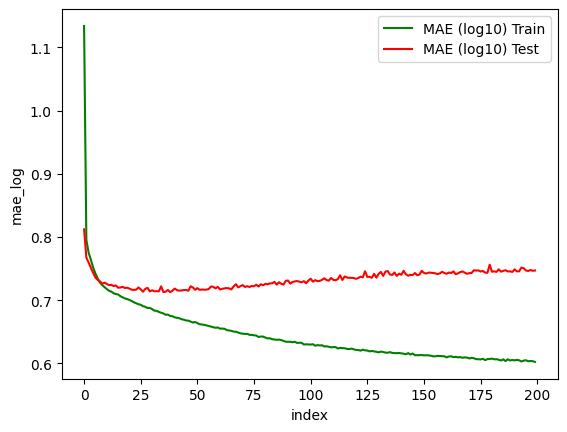

In [107]:
history_df = pd.DataFrame(history.history).reset_index()
history_df['mae_log'] = np.log10(history_df['mae'] )
history_df['val_mae_log'] = np.log10(history_df['val_mae'] )
sns.lineplot(data=history_df, x="index", y="mae_log", color="green", label="MAE (log10) Train")
sns.lineplot(data=history_df, x="index", y="val_mae_log", color="red", label="MAE (log10) Test")

Este gráfico nos dice que conviene disminuir las epochs por lo que finalmente usaremos 25

# Poniendo a prueba el modelo

In [109]:
pred = model.predict(X_validation)

11/11 [==============================] - 0s 5ms/step


## Métricas

In [110]:
# model evaluation for testing set
mae = metrics.mean_absolute_error(y_validation, pred)
mse = metrics.mean_squared_error(y_validation, pred)
r2 = metrics.r2_score(y_validation, pred)
print('MAE: {}'.format(mae))
print('MSE: {}'.format(mse))
print('R2: {}'.format(r2))

MAE: 5.452414425807213
MSE: 45.82509266780847
R2: 0.56007029807476


In [111]:
count_mean = validation['COUNT'].mean()
print('Media ' + str(count_mean))
print('Porcentaje de error con respecto a la media ' + str(mae/count_mean))

Media 28.074626865671643
Porcentaje de error con respecto a la media 0.1942114654593744


## 5 días para comparar predicción vs realidad

In [112]:
cantidad = 12 * 5
final = validation.copy().astype(str)
final['COUNT'] = validation.copy()['COUNT'].astype(int)
final['PRED'] = pred
final['DIFF'] = final['PRED'] - final['COUNT']
final['FECHA'] = final['MES'] + '-' + final['DIA'] + '-' + final['DIA DE LA SEMANA'] + '-' + final['HORA']

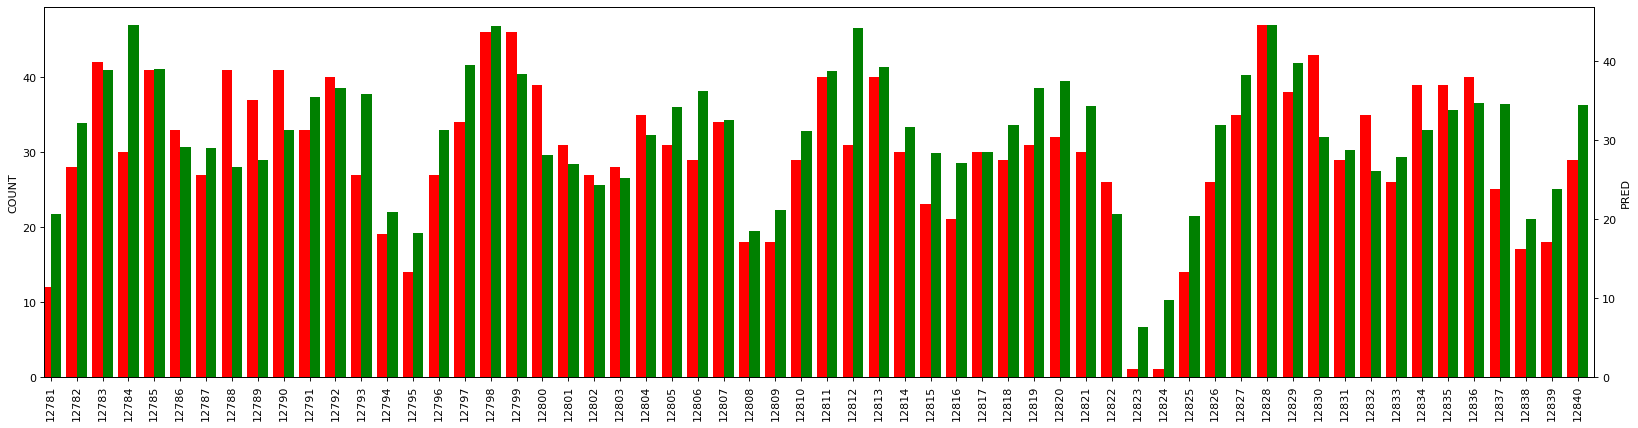

In [113]:
fig = plt.figure(figsize=(25, 6), dpi=80)

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

final[:cantidad]['COUNT'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
final[:cantidad]['PRED'].plot(kind='bar', color='green', ax=ax2, width=width, position=0)

ax.set_ylabel('COUNT')
ax2.set_ylabel('PRED')

plt.show()

## Gráfico de diferencia predicción vs realidad

<Axes: xlabel='FECHA', ylabel='DIFF'>

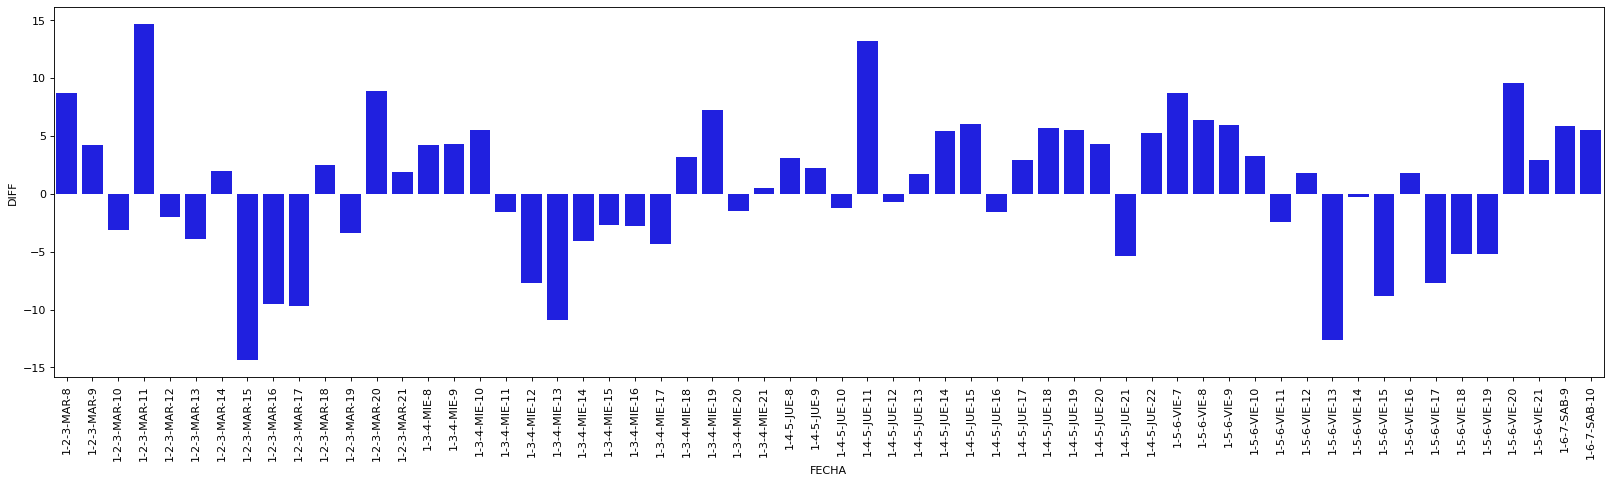

In [114]:
plt.figure(figsize=(25, 6), dpi=80)
plt.xticks(rotation='vertical')
sns.barplot(data=final[:cantidad], x='FECHA', y='DIFF', color='blue')

### Conclusiones

 Era de esperarse que el modelo no pueda predecir con total exactitud la cantidad de gente que llega a un local porque esto depende de muchísimos factores. Sin embargo se pudo obtener una precisión muy aceptable, con un error medio absoluto de poco mas de 5 personas por hora.

 Estos resultados son suficientes para poder determinar qué tan concurrido será el día y tomar deciciones como mover empleados de una sucursal a otra para reducir los tiempos de espera de los clientes.